This notebook is an ensemble of tests I did for the project.

### Qiskit Error Channel Notebook

This notebook was taken from Qiskit: https://qiskit.github.io/qiskit-aer/tutorials/3_building_noise_models.html

In [2]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
# from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

In [3]:
# import plot_histogram
from qiskit.visualization import plot_histogram

In [13]:
# Construct a 1-qubit bit-flip and phase-flip errors
p_error = 0.05
bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])
phase_flip = pauli_error([('Z', p_error), ('I', 1 - p_error)])
print(bit_flip)
print(phase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘
QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ Z ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘


In [8]:
# Compose two bit-flip and phase-flip errors
bitphase_flip = bit_flip.compose(phase_flip)
print(bitphase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ Z ├
   └───┘└───┘
  P(1) = 0.0475, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ I ├
   └───┘└───┘
  P(2) = 0.0475, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ Z ├
   └───┘└───┘
  P(3) = 0.9025, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ I ├
   └───┘└───┘


In [9]:
# Tensor product two bit-flip and phase-flip errors with
# bit-flip on qubit-0, phase-flip on qubit-1
error2 = phase_flip.tensor(bit_flip)
print(error2)

QuantumError on 2 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, Circuit = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ Z ├
     └───┘
  P(1) = 0.0475, Circuit = 
     ┌───┐
q_0: ┤ I ├
     ├───┤
q_1: ┤ Z ├
     └───┘
  P(2) = 0.0475, Circuit = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ I ├
     └───┘
  P(3) = 0.9025, Circuit = 
     ┌───┐
q_0: ┤ I ├
     ├───┤
q_1: ┤ I ├
     └───┘


In [10]:
# System Specification
n_qubits = 4
circ = QuantumCircuit(n_qubits)

# Test Circuit
circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
circ.measure_all()
print(circ)

        ┌───┐                ░ ┌─┐         
   q_0: ┤ H ├──■─────────────░─┤M├─────────
        └───┘┌─┴─┐           ░ └╥┘┌─┐      
   q_1: ─────┤ X ├──■────────░──╫─┤M├──────
             └───┘┌─┴─┐      ░  ║ └╥┘┌─┐   
   q_2: ──────────┤ X ├──■───░──╫──╫─┤M├───
                  └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────┤ X ├─░──╫──╫──╫─┤M├
                       └───┘ ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════╩══╩══╩══╩═
                                0  1  2  3 


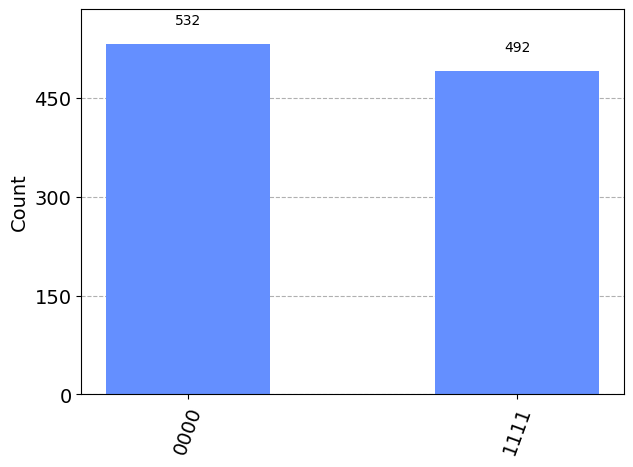

In [14]:
# Ideal simulator and execution
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(circ).result()
plot_histogram(result_ideal.get_counts(0))

In [15]:
# Example error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'u1', 'reset', 'measure', 'u2', 'cx']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


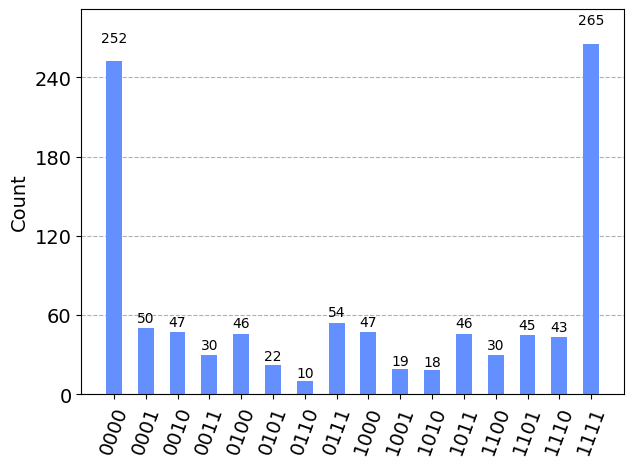

In [17]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_bit_flip)

# Transpile circuit for noisy basis gates
circ_tnoise = transpile(circ, sim_noise)

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_bit_flip)

In [18]:
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u2', 'u3']
  Instructions with noise: ['u3', 'cx', 'reset', 'measure', 'u2']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('u2', (0,)), ('u2', (1,)), ('u2', (2,)), ('u2', (3,)), ('u3', (0,)), ('u3', (1,)), ('u3', (2,)), ('u3', (3,)), ('cx', (0, 0)), ('cx', (0, 1)), ('cx', (0, 2)), ('cx', (0, 3)), ('cx', (1, 0)), ('cx', (1, 1)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (2, 0)), ('cx', (2, 1)), ('cx', (2, 2)), ('cx', (2, 3)), ('cx', (3, 0)), ('cx', (3, 1)), ('cx', (3, 2)), ('cx', (3, 3))]


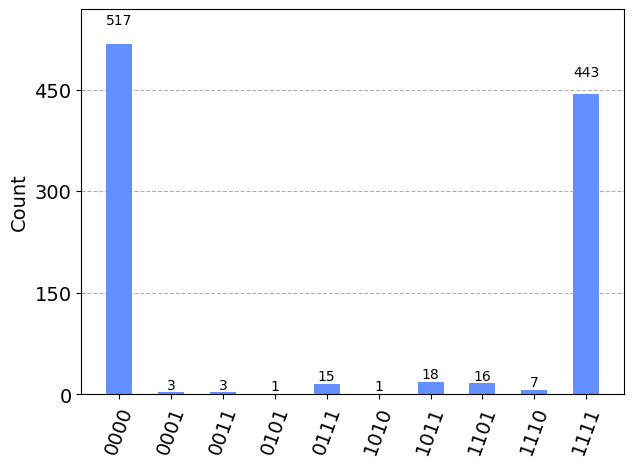

In [19]:
# Run the noisy simulation
sim_thermal = AerSimulator(noise_model=noise_thermal)

# Transpile circuit for noisy basis gates
circ_tthermal = transpile(circ, sim_thermal)

# Run and get counts
result_thermal = sim_thermal.run(circ_tthermal).result()
counts_thermal = result_thermal.get_counts(0)

# Plot noisy output
plot_histogram(counts_thermal)

### An Attempt at the Steane Code

        ┌───┐                    ┌───┐                               ░ ┌─┐   »
   q_0: ┤ H ├──■────■─────────■──┤ H ├───────────────────────────────░─┤M├───»
        ├───┤  │    │         │  └───┘               ┌───┐           ░ └╥┘┌─┐»
   q_1: ┤ H ├──┼────┼────■────┼────■──────────────■──┤ H ├───────────░──╫─┤M├»
        ├───┤  │    │    │    │    │              │  └───┘     ┌───┐ ░  ║ └╥┘»
   q_2: ┤ H ├──┼────┼────┼────┼────┼────■─────────┼────■────■──┤ H ├─░──╫──╫─»
        ├───┤┌─┴─┐  │  ┌─┴─┐  │    │    │  ┌───┐  │    │    │  └───┘ ░  ║  ║ »
   q_3: ┤ H ├┤ X ├──┼──┤ X ├──┼────┼────┼──┤ H ├──┼────┼────┼────────░──╫──╫─»
        ├───┤└───┘  │  └───┘  │  ┌─┴─┐  │  └───┘  │  ┌─┴─┐  │  ┌───┐ ░  ║  ║ »
   q_4: ┤ H ├───────┼─────────┼──┤ X ├──┼─────────┼──┤ X ├──┼──┤ H ├─░──╫──╫─»
        ├───┤     ┌─┴─┐       │  └───┘┌─┴─┐┌───┐  │  └───┘  │  └───┘ ░  ║  ║ »
   q_5: ┤ H ├─────┤ X ├───────┼───────┤ X ├┤ H ├──┼─────────┼────────░──╫──╫─»
        ├───┤┌───┐└───┘     ┌─┴─┐     └───┘└───┘┌─┴─

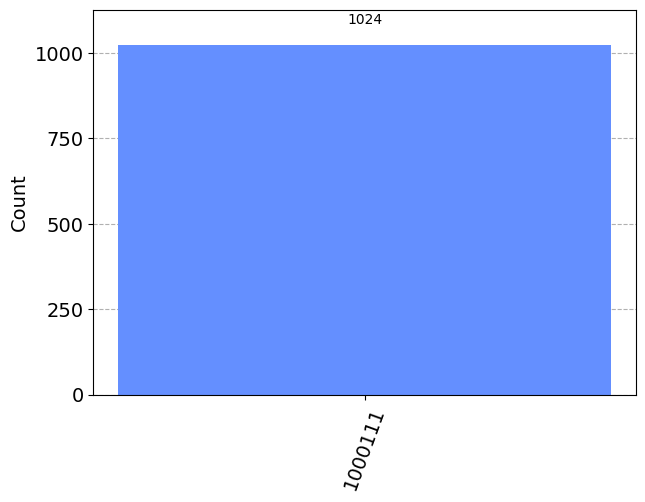

In [27]:
# Construct a Steane code stabilizer circuit
n_qubits = 7
circ_steane = QuantumCircuit(n_qubits)

circ_steane.x(6)

# Apply Hadamard gate to all qubits
for qubit in range(n_qubits):
    circ_steane.h(qubit)
    
# Apply CNOT gates
circ_steane.cx(0, 3)
circ_steane.cx(0, 5)
circ_steane.cx(0, 6)
circ_steane.cx(1, 3)
circ_steane.cx(1, 4)
circ_steane.cx(1, 6)
circ_steane.cx(2, 5)
circ_steane.cx(2, 4)
circ_steane.cx(2, 6)

# Apply Hadamard gate to all qubits
for qubit in range(n_qubits):
    circ_steane.h(qubit)
    
# Measure all qubits
circ_steane.measure_all()
print(circ_steane)

# Run the ideal simulation
sim_steane_ideal = AerSimulator()
result_steane_ideal = sim_steane_ideal.run(circ_steane).result()
counts_steane_ideal = result_steane_ideal.get_counts(0)

# Plot ideal output
plot_histogram(counts_steane_ideal)

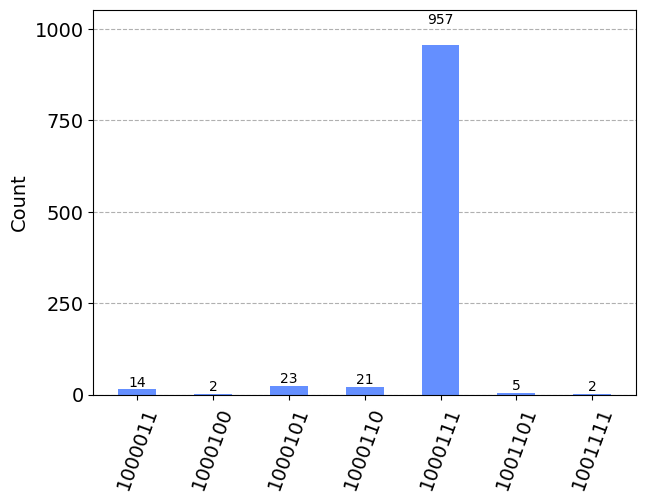

In [28]:
# Run the noisy simulation
sim_steane_thermal = AerSimulator(noise_model=noise_thermal)

# Transpile circuit for noisy basis gates
circ_steane_tthermal = transpile(circ_steane, sim_steane_thermal)

# Run and get counts
result_steane_thermal = sim_steane_thermal.run(circ_steane_tthermal).result()
counts_steane_thermal = result_steane_thermal.get_counts(0)

# Plot noisy output
plot_histogram(counts_steane_thermal)

### Backend Noise Simulator

Backend noise simulators take the inherent infidelity of gates into account. Notebook adopted from https://qiskit.github.io/qiskit-aer/tutorials/2_device_noise_simulation.html.

In [3]:
from qiskit import transpile
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

In [4]:
import qiskit.providers.fake_provider as fp
device_backend = fp.GenericBackendV2(num_qubits=5)

        ┌───┐                     ░ ┌─┐            
   q_0: ┤ H ├──■──────────────────░─┤M├────────────
        └───┘┌─┴─┐                ░ └╥┘┌─┐         
   q_1: ─────┤ X ├──■─────────────░──╫─┤M├─────────
             └───┘┌─┴─┐           ░  ║ └╥┘┌─┐      
   q_2: ──────────┤ X ├──■────────░──╫──╫─┤M├──────
                  └───┘┌─┴─┐      ░  ║  ║ └╥┘┌─┐   
   q_3: ───────────────┤ X ├──■───░──╫──╫──╫─┤M├───
                       └───┘┌─┴─┐ ░  ║  ║  ║ └╥┘┌─┐
   q_4: ────────────────────┤ X ├─░──╫──╫──╫──╫─┤M├
                            └───┘ ░  ║  ║  ║  ║ └╥┘
meas: 5/═════════════════════════════╩══╩══╩══╩══╩═
                                     0  1  2  3  4 


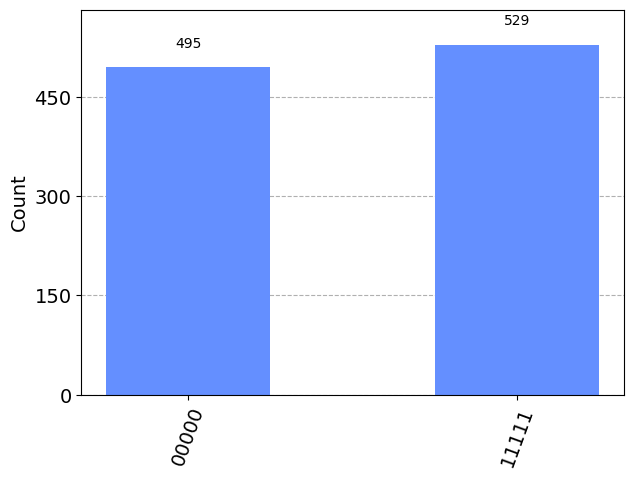

In [48]:
# Construct a 5-qubit GHZ state
n_qubits = 5
circ = QuantumCircuit(n_qubits)
circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
circ.measure_all()
print(circ)

# Run the ideal simulation
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(circ).result()
counts_ideal = result_ideal.get_counts(0)

# Plot ideal output
plot_histogram(counts_ideal)

In [49]:
sim_vigo = AerSimulator.from_backend(device_backend)

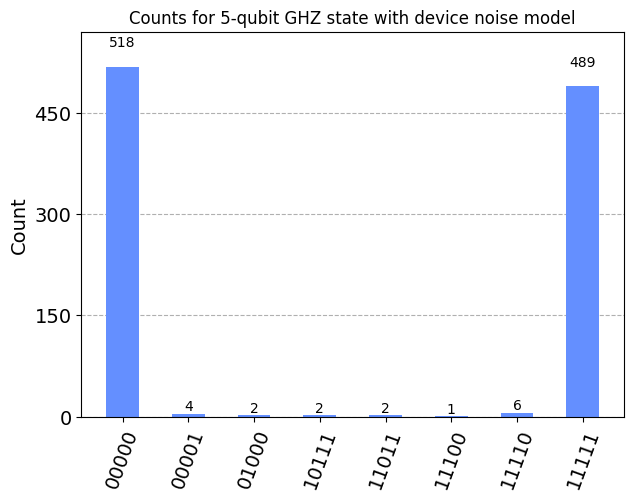

In [50]:
# Transpile the circuit for the noisy basis gates
tcirc = transpile(circ, sim_vigo)

# Execute noisy simulation and get counts
result_noise = sim_vigo.run(tcirc).result()
counts_noise = result_noise.get_counts(0)
plot_histogram(counts_noise,
               title="Counts for 5-qubit GHZ state with device noise model")

### Error Correction with the Steane Code

This part of my code is adapted from https://github.com/KnightShuffler/Steane-Code-in-Qiskit/blob/main/task2.ipynb. I updated the code to make it modern qiskit language and also compatible with noise models.

In [2]:
from qiskit import QuantumRegister, ClassicalRegister

The function below constructs the logical qubit for the Steane code.

In [4]:
def error_correction(qc, x_ancillas, z_ancillas, logical_qubit, x_syndrome, z_syndrome):
    # Make sure inputs are valid
    if not isinstance(qc, QuantumCircuit):
        raise TypeError("'qc', should be a QuantumCircuit")
    
    if not isinstance(x_ancillas, QuantumRegister):
        raise TypeError("'x_ancillas' should be a QuantumRegister")
    elif x_ancillas.size != 3:
        raise TypeError("'x_ancillas' must have 3 qubits")
        
    if not isinstance(z_ancillas, QuantumRegister):
        raise TypeError("'z_ancillas' should be a QuantumRegister")
    elif z_ancillas.size != 3:
        raise TypeError("'z_ancillas' must have 3 qubits")
    
    if not isinstance(logical_qubit, QuantumRegister):
        raise TypeError("'logical_qubit' should be a QuantumRegister")
    elif logical_qubit.size != 7:
        raise TypeError("'logical_qubit' must have 7 qubits")
    
    if not isinstance(x_syndrome, ClassicalRegister):
        raise TypeError("'x_syndrome' should be a ClassicalRegister")
    elif x_syndrome.size != 3:
        raise TypeError("'x_syndrome' must have 3 bits")
        
    if not isinstance(z_syndrome, ClassicalRegister):
        raise TypeError("'z_syndrome' should be a ClassicalRegister")
    elif z_syndrome.size != 3:
        raise TypeError("'z_syndrome' must have 3 bits")
        
    # Initialize the ancillas to |0>
    for i in range(3):
        qc.initialize([1,0], x_ancillas[i])
        qc.initialize([1,0], z_ancillas[i])
        
    # Apply Hadamard to the ancillas
    qc.h(x_ancillas)
    qc.h(z_ancillas)
    
    # Controlled g_i
    qc.cx(z_ancillas[2], [logical_qubit[i-1] for i in [4,5,6,7]]) # Controlled g1
    qc.cx(z_ancillas[1], [logical_qubit[i-1] for i in [2,3,6,7]]) # Controlled g2
    qc.cx(z_ancillas[0], [logical_qubit[i-1] for i in [1,3,5,7]]) # Controlled g3
    
    qc.cz(x_ancillas[2], [logical_qubit[i-1] for i in [4,5,6,7]]) # Controlled g4
    qc.cz(x_ancillas[1], [logical_qubit[i-1] for i in [2,3,6,7]]) # Controlled g5
    qc.cz(x_ancillas[0], [logical_qubit[i-1] for i in [1,3,5,7]]) # Controlled g6
    
    # Apply Hadamard to the ancillas
    qc.h(x_ancillas)
    qc.h(z_ancillas)
    
    # Measure the ancillas
    qc.measure(x_ancillas, x_syndrome)
    qc.measure(z_ancillas,z_syndrome)
    
    # Apply the corrective X gates
    for i in range(1,8):
        qc.x(logical_qubit[i-1]).c_if(x_syndrome,i)
    
    # Apply the corrective Z gates
    for i in range(1,8):
        qc.z(logical_qubit[i-1]).c_if(z_syndrome,i)

In [ ]:
# initialize circuit
lq = QuantumRegister(7)
x_anc  = QuantumRegister(3)
x_syn  = ClassicalRegister(3)
z_anc  = QuantumRegister(3)
z_syn  = ClassicalRegister(3)

qc = QuantumCircuit(x_anc,z_anc,lq,x_syn,z_syn)
error_correction(qc, x_anc, z_anc, lq, x_syn, z_syn)

Now we construct the logical gates for the Steane Code:

In [5]:
# Adds the logical Hadamard  gate to a QuantumCircuit qc
def logical_h(qc, logical_qubit):
    if not isinstance(qc, QuantumCircuit):
        raise TypeError("'qc', should be a QuantumCircuit")
        
    if not isinstance(logical_qubit, QuantumRegister):
        raise TypeError("'logical_qubit' should be a QuantumRegister")
    elif logical_qubit.size != 7:
        raise TypeError("'logical_qubit' must have 7 qubits")

    qc.h(logical_qubit)
    
# Adds the logical CNOT gate to a QuantumCircuit qc with logical qubit 'control' as the control
# and 'target' as target
def logical_cx(qc, control, target):
    if not isinstance(qc, QuantumCircuit):
        raise TypeError("'qc', should be a QuantumCircuit")
        
    if not isinstance(control, QuantumRegister):
        raise TypeError("'control' should be a QuantumRegister")
    elif control.size != 7:
        raise TypeError("'control' must have 7 qubits")
    
    if not isinstance(control, QuantumRegister):
        raise TypeError("'control' should be a QuantumRegister")
    elif control.size != 7:
        raise TypeError("'control' must have 7 qubits")

    for i in range(7):
        qc.cx(control[i],target[i])
        
# Measures logical_qubit in the Z basis using ancilla, in the circuit qc
def logical_z_measure(qc, ancilla, logical_qubit, measurement):
    # Make sure the inputs are valid
    if not isinstance(qc, QuantumCircuit):
        raise TypeError("'qc' should be a QuantumCircuit")
    
    if not isinstance(ancilla, QuantumRegister):
        raise TypeError("'ancilla' should be a QuantumRegister")
    elif ancilla.size != 1:
        raise TypeError("'ancilla' must have 1 qubit")
    
    if not isinstance(logical_qubit, QuantumRegister):
        raise TypeError("'logical_qubit'should be a QuantumRegister")
    elif logical_qubit.size != 7:
        raise TypeError("'logical_qubit' must have 7 qubits")
    
    if not isinstance(measurement, ClassicalRegister):
        raise TypeError("'measurement' should be a ClassicalRegister")
    elif measurement.size != 1:
        raise TypeError("'measurement' must have 1 bit")
        
    # Initialize ancilla to |0>
    qc.initialize([1,0],ancilla)
    
    # Apply Hadamard to ancilla
    qc.h(ancilla)
    # Apply controlled logical-Z
    for i in range(7):
        qc.cz(ancilla, logical_qubit[i])
    # Apply Hadamard to ancilla
    qc.h(ancilla)
    
    # Measure the ancilla
    qc.measure(ancilla, measurement)

This function adds a random error gate to the circuit.

In [6]:
def addDiscreteErrorGate(qubit, prob, error_gates):
    n = len(error_gates)
    
    # Check to make sure n*prob<=1
    if(n*prob > 1):
        raise ValueError('The entered probability is invalid, {}*prob > 1'.format(n))
    
    rand = np.random.uniform(0,1)
    #print(rand) # Debugging line
    
    # Apply error_gate[i] if the randomly generated number is between i*prob and (i+1)*prob
    for i in range(n):
        if rand < (i+1)*prob:
            error_gates[i](qubit)
            return

The function below we build an entire circuit and the error correction codes associated with it:

In [7]:
# error_levels:
# 0 - No errors
# 1 - Exactly one bit flip and one phase flip error on any one physical qubit of each logical qubit
# 2 - Bit and Phase flip possible on every physical qubit

def BellCircuit_With_EC(error_prob=0, error_level=0):
    # The logical qubits
    lq_1 = QuantumRegister(7,name='lq_1')
    lq_2 = QuantumRegister(7,name='lq_2')

    # Error Correction Ancillas
    x_ec_ancilla = QuantumRegister(3,name='x_ec_ancil')
    z_ec_ancilla = QuantumRegister(3,name='z_ec_ancil')
    
    x_ec_syndrome = ClassicalRegister(3,name='x_ec_synd')
    z_ec_syndrome = ClassicalRegister(3,name='z_ec_synd')
    
    # Measurement Ancillas
    z_meas_ancilla_1 = QuantumRegister(1,name='meas_ancil_1')
    z_meas_ancilla_2 = QuantumRegister(1,name='meas_ancil_2')

    z_meas_1 = ClassicalRegister(1,name='meas 1')
    z_meas_2 = ClassicalRegister(1,name='meas 2')

    # Define the quantum circuit on these registers
    qc = QuantumCircuit(lq_1, lq_2,
                        x_ec_ancilla, z_ec_ancilla, z_meas_ancilla_1, z_meas_ancilla_2,
                        x_ec_syndrome, z_ec_syndrome, z_meas_1, z_meas_2)
    
    # A function to introduce error dependent on the error_level
        # post_H is a flag for error_level=1, to check if the function is called right 
        # after the Hadamard
    def introduce_error():
        if not isinstance(error_level, int):
            raise TypeError("'error_level' must be an integer")
        if error_level < 0 or error_level > 3:
            raise ValueError("'error_level' must be between 0 and 3, inclusive")
        
        if error_level == 0: # no error
            return
        
        if error_level == 1: # Exactly one error anywhere
            qc.x(lq_1[np.random.randint(0,6+1)])
            qc.z(lq_1[np.random.randint(0,6+1)])

            qc.x(lq_2[np.random.randint(0,6+1)])
            qc.z(lq_2[np.random.randint(0,6+1)])
            return
        
        if error_level == 2: # Bit/Phase flips possible on every physical qubit
            for i in range(7):
                addDiscreteErrorGate(lq_1[i], error_prob, [qc.x, qc.z])
                addDiscreteErrorGate(lq_1[i], error_prob, [qc.x, qc.z])
            return
    
    # Initialize the logical qubits to the 0 state
    error_correction(qc, x_ec_ancilla, z_ec_ancilla, lq_1, x_ec_syndrome, z_ec_syndrome)
    error_correction(qc, x_ec_ancilla, z_ec_ancilla, lq_2, x_ec_syndrome, z_ec_syndrome)

    # Apply the Hadamard gate
    logical_h(qc, lq_1)    
    introduce_error()
    
    error_correction(qc, x_ec_ancilla, z_ec_ancilla, lq_1, x_ec_syndrome, z_ec_syndrome)
    error_correction(qc, x_ec_ancilla, z_ec_ancilla, lq_2, x_ec_syndrome, z_ec_syndrome)

    # Apply the CNOT gate
    logical_cx(qc, lq_1, lq_2)
    introduce_error()
    
    error_correction(qc, x_ec_ancilla, z_ec_ancilla, lq_1, x_ec_syndrome, z_ec_syndrome)
    error_correction(qc, x_ec_ancilla, z_ec_ancilla, lq_2, x_ec_syndrome, z_ec_syndrome)

    # Measure the qubits
    logical_z_measure(qc, z_meas_ancilla_1, lq_1, z_meas_1)
    logical_z_measure(qc, z_meas_ancilla_2, lq_2, z_meas_2)
    
    return qc

In [8]:
N = 100   # Number of noisy circuits generated
p = 0.1   # Probability of an error, max 0.5 because the error can be X or Z

Unfortunately my computer doesn't have the computing capacity for running error-correction codes (it ran the function for more than 10 minutes without returning anything), so I aborted.

In [5]:
sim_ideal = AerSimulator()
sim_noise = AerSimulator.from_backend(device_backend)

In [6]:
# Error Level 0 - error-free circuit

def BellCircuit_With_EC(p, error_level):
    net_counts = {}
    for i in range(N):
        # Generate a noisy circuit
        qc = BellCircuit_With_EC(p,error_level)
        t_qc = transpile(qc, sim_noise)
        
        # Get measurement outcomes
        result = sim_noise.run(t_qc).result()
        counts = result.get_counts()

        # We want to extract only the final measurements, which are the right-most 2 bits 
        # in the counts dictionary key string
        for key in counts.keys():
            # truncate the measurement string to include the Z-measurements
            truncated_key = key[0:3][::-1] # Reversed to match order lq_1 lq_2
            if truncated_key in net_counts.keys():
                net_counts[truncated_key] += counts[key]
            else:
                net_counts[truncated_key] = counts[key]

    plot_histogram(net_counts)

In [ ]:
BellCircuit_With_EC(p,0)

In [ ]:
BellCircuit_With_EC(p,1)

In [ ]:
BellCircuit_With_EC(p,2)